In [21]:
# Import Packages
import time
import numpy as np

from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import seaborn as sns

from tqdm import tqdm
import scipy
from scipy.special import factorial, factorial2, erfinv, erf
from scipy.stats import kurtosis

import jax
import jax.numpy as jnp
from jax import random, jit, vmap
from functools import partial
from math import comb

import matplotlib as mpl
from IPython.display import clear_output, display


import seaborn as sns
sns.set_style("white")
sns.set_context("poster")

key = jax.random.PRNGKey(2023)

# Helper Functions

In [23]:
def generate_patterns(key, num_neurons, num_patterns):
    patterns = random.bernoulli(key, p=0.5, shape=(num_patterns, num_neurons)) 
    return jnp.where(patterns, 1, -1).astype('float32') # Change True to 1 and False to -1

def generate_correlated_patterns(key, eps, num_neurons, num_patterns):
    patterns = random.bernoulli(key, p=0.5 + 0.5*eps, shape=(num_patterns, num_neurons)) 
    return jnp.where(patterns, 1, -1).astype('float32') # Change True to 1 and False to -1

def generate_sequences(key, num_neurons, num_patterns, num_sequences=100):
    seq_list = []
    for s in range(num_sequences):
        key, _ = random.split(key)
        seq_list += [generate_patterns(key, num_patterns, num_neurons)]
    sequences = jnp.stack(seq_list).reshape(num_sequences, num_patterns, num_neurons)
    return sequences

In [24]:
# Polynomial Network Theory
def theory_PDN_trans(N, d):
    return N**d / (2 * factorial2(2*d-1) * jnp.log(N))

def theory_PDN_seq(N, d):
    return N**d / (2 * (d+1) * factorial2(2*d-1) * jnp.log(N))

def gamma(d_S, d_A, lambd):
    if d_S < d_A:
        return factorial2(2*d_S-1)
    elif d_S == d_A:
        return (lambd**2 + 1)*factorial2(2*d_S-1) + 2*lambd*factorial2(d_S-1)**2  * (d_S % 2 == 0)
    else:
        return lambd**2 * factorial2(2*d_A-1)

def theory_PMN_trans(N, d_A, d_S, lambd):
    return (lambd-1)**2 / (2 * gamma(d_S, d_A, lambd)) * N**(np.min([d_S, d_A]))/ jnp.log(N)

def theory_PMN_seq(N, d_A, d_S, lambd):
    return (lambd-1)**2 / (2 * gamma(d_S, d_A, lambd) * np.min([d_S,d_A])) * N**(np.min([d_S, d_A]))/ jnp.log(N)

# Exponential Network Theory
beta = jnp.exp(2) / jnp.cosh(2)

def theory_EDN_trans(N):
    return beta**(N-1) / (2 * jnp.log(N))

def theory_EDN_seq(N):
    return beta**(N-1) / (2 * jnp.log(beta) * N)

def theory_EMN_trans(N, lambd):
    return (lambd-1)**2 / (lambd**2 + 1) * theory_EDN_trans(N)

def theory_EMN_seq(N, lambd):
    return (lambd-1)**2 / (lambd**2 + 1) * theory_EDN_seq(N)

# DenseNet Capacity

<ipython-input-17-4a384ea7e677>:13: RuntimeWarning: divide by zero encountered in log10
  poly_trans_sim_log = np.log10(np.load('final_logs/PDN_transition_capacity.npy'))
/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


FileNotFoundError: [Errno 2] No such file or directory: 'final_logs/EDN_transition_capacity.npy'

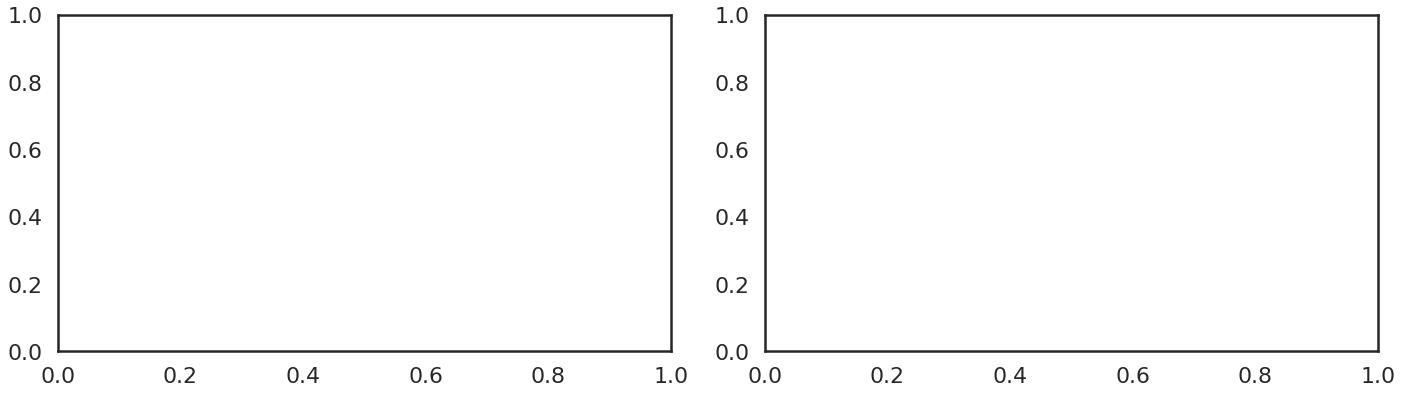

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

ds = np.linspace(1,4,4).astype('int')
Ns = np.linspace(10,100,10).astype('int')
exp_Ns = np.linspace(1,50,50).astype('int')

poly_trans_theory_log = np.array([[np.log10(theory_PDN_trans(N, d)) for N in Ns] for d in ds])
poly_seq_theory_log = np.array([[np.log10(theory_PDN_seq(N, d)) for N in Ns] for d in ds])

exp_trans_theory_log = np.array([np.log10(theory_EDN_trans(N)) for N in exp_Ns])
exp_seq_theory_log = np.array([np.log10(theory_EDN_seq(N)) for N in exp_Ns])

poly_trans_sim_log = np.log10(np.load('final_logs/PDN_transition_capacity.npy'))
poly_trans_sim_log_mean, poly_trans_sim_log_std = np.mean(poly_trans_sim_log, axis=2), np.std(poly_trans_sim_log, axis=2)

exp_trans_sim_log = np.log10(np.load('final_logs/EDN_transition_capacity.npy'))
exp_trans_sim_log_mean, exp_trans_sim_log_std = np.mean(exp_trans_sim_log, axis=1), np.std(exp_trans_sim_log, axis=1)

poly_seq_sim_log = np.log10(np.load('final_logs/PDN_sequence_capacity.npy'))
poly_seq_sim_log_mean, poly_seq_sim_log_std = np.mean(poly_seq_sim_log, axis=2), np.std(poly_seq_sim_log, axis=2)

exp_seq_sim_log = np.log10(np.load('final_logs/EDN_sequence_capacity.npy'))
exp_seq_sim_log_mean, exp_seq_sim_log_std = np.mean(exp_seq_sim_log, axis=1), np.std(exp_seq_sim_log, axis=1)

c = np.arange(1, 6)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)
cmap.set_array([])

# Transitions
for i_d, d in enumerate(ds):
    axes[0].plot(Ns, poly_trans_theory_log[i_d], color=cmap.to_rgba(i_d + 2), label = f'Theory: Poly (d={d})')
    
axes[0].plot(exp_Ns[9:25], exp_trans_theory_log[9:25], color='blue', label = f'Theory: Exp')

for i_d, d in enumerate(ds):
    axes[0].errorbar(Ns, poly_trans_sim_log_mean[i_d], poly_trans_sim_log_std[i_d], linestyle='None', capsize = 10, color=cmap.to_rgba(i_d + 2), label=f'Sim: Poly (d={d})')
    
axes[0].errorbar(exp_Ns[9:25], exp_trans_sim_log_mean[9:25], exp_trans_sim_log_std[9:25], linestyle='None', color='blue', capsize=10, label = f'Sim: Exp')

axes[0].set_xlabel('N', fontsize = 25)
axes[0].set_xticks(Ns)
axes[0].set_xlim(5,105)
axes[0].set_ylim(0, 7)
axes[0].set_yticks(list(range(8)))
axes[0].set_ylabel('$log_{10} (P_T)$', fontsize = 25)

# Sequences
for i_d, d in enumerate(ds):
    axes[1].plot(Ns, poly_seq_theory_log[i_d], color=cmap.to_rgba(i_d + 2), label = f'Theory: Poly (d={d})')

axes[1].plot(exp_Ns[9:25], exp_seq_theory_log[9:25], color='blue', label = f'Theory: Exp')

for i_d, d in enumerate(ds):
    axes[1].errorbar(Ns, poly_seq_sim_log_mean[i_d], poly_seq_sim_log_std[i_d], linestyle='None', capsize = 10, color=cmap.to_rgba(i_d + 2), label=f'Sim: Poly (d={d})')
    
axes[1].errorbar(exp_Ns[9:25], exp_seq_sim_log_mean[9:25], exp_seq_sim_log_std[9:25], linestyle='None', color='blue', capsize=10, label = f'Sim: Exp')

axes[1].set_xlabel('N', fontsize = 25)
axes[1].set_xticks(Ns)
axes[1].set_xlim(5,105)
axes[1].set_ylim(0, 7)
axes[1].set_yticks(list(range(8)))
axes[1].set_ylabel('$log_{10} (P_S)$', fontsize = 25)
axes[1].legend(fontsize=14, ncol=2, loc= 'upper right')

fig.savefig(f'plots/DN_capacity.pdf', bbox_inches='tight', dpi=300, format = 'pdf')

# MixedNet Capacity

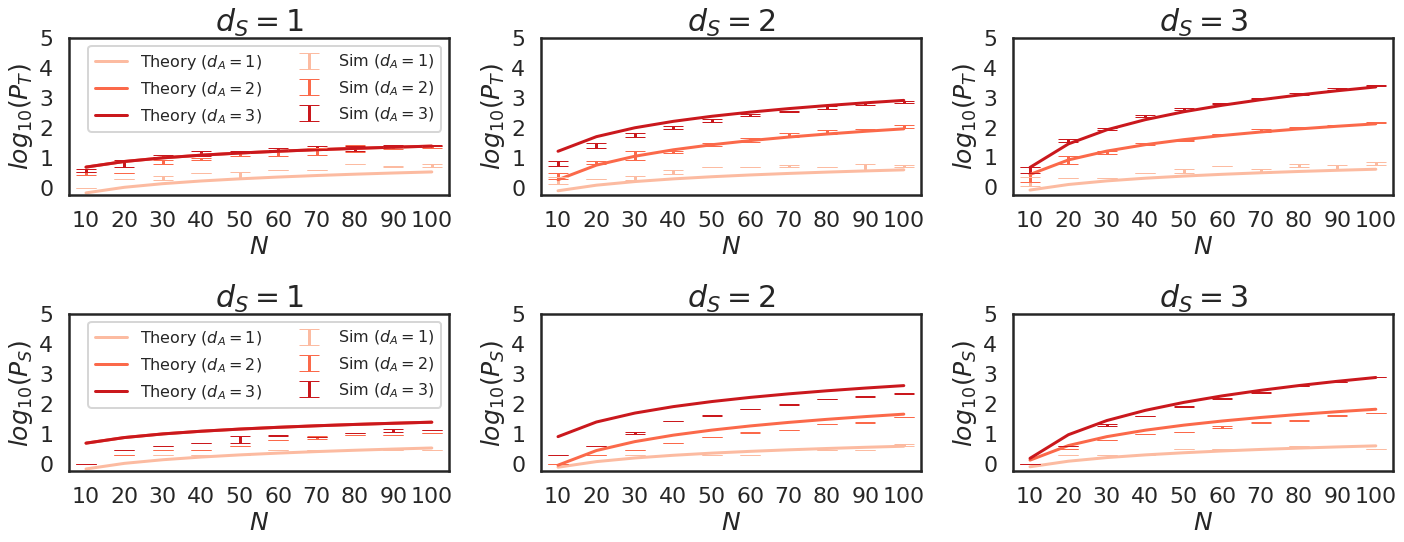

In [10]:
# Plot Polynomial Mixed Network Results
ds = np.linspace(1,3,3).astype('int')
Ns = np.linspace(10,100,10).astype('int')

lambd = 2.5
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))

# Plot Polynomial Mixed Network Results

PMN_trans_theory_log = np.array([[[np.log10(theory_PMN_trans(N, d_A, d_S, lambd)) for N in Ns] for d_A in ds] for d_S in ds])
PMN_trans_sim_log = np.log10(np.load('final_logs/PMN_transition_capacity.npy'))
PMN_trans_sim_log_mean, PMN_trans_sim_log_std = np.mean(PMN_trans_sim_log, axis=3), np.std(PMN_trans_sim_log, axis=3)

import matplotlib as mpl
c = np.arange(1, 6)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)
cmap.set_array([])

for i_dS, dS in enumerate(ds):
    for i_dA, dA in enumerate(ds):
        if i_dS == 0:
            axes[0, i_dS].plot(Ns, PMN_trans_theory_log[i_dS, i_dA], color=cmap.to_rgba(i_dA + 2), label = f'Theory ($d_A = {dA}$)')
        else:
            axes[0, i_dS].plot(Ns, PMN_trans_theory_log[i_dS, i_dA], color=cmap.to_rgba(i_dA + 2))
    for i_dA, dA in enumerate(ds):
        if i_dS == 0:
            axes[0, i_dS].errorbar(Ns, PMN_trans_sim_log_mean[i_dS, i_dA], PMN_trans_sim_log_std[i_dS, i_dA], linestyle='None', capsize = 10, color=cmap.to_rgba(i_dA + 2), label=f'Sim ($d_A={dA}$)')
        else:
            axes[0, i_dS].errorbar(Ns, PMN_trans_sim_log_mean[i_dS, i_dA], PMN_trans_sim_log_std[i_dS, i_dA], linestyle='None', capsize = 10, color=cmap.to_rgba(i_dA + 2))

    axes[0, i_dS].set_xlabel('$N$', size=25)
    axes[0, i_dS].set_xticks(Ns)
    axes[0, i_dS].set_yticks(list(range(6)))
    axes[0, i_dS].set_ylabel('$log_{10}(P_T)$', fontsize = 25)
    axes[0, i_dS].set_title(f'$d_S = {dS}$', size=30)

axes[0,0].legend(fontsize=16, ncol=2, loc= 'upper right')

PMN_seq_theory_log = np.array([[[np.log10(theory_PMN_seq(N, d_A, d_S, lambd)) for N in Ns] for d_A in ds] for d_S in ds])

PMN_seq_sim_log = np.log10(np.load('final_logs/PMN_sequence_capacity.npy'))
PMN_seq_sim_log_mean, PMN_seq_sim_log_std = np.mean(PMN_seq_sim_log, axis=3), np.std(PMN_seq_sim_log, axis=3)


import matplotlib as mpl
c = np.arange(1, 6)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)
cmap.set_array([])

for i_dS, dS in enumerate(ds):
    for i_dA, dA in enumerate(ds):
        if i_dS == 0:
            axes[1, i_dS].plot(Ns, PMN_seq_theory_log[i_dS, i_dA], color=cmap.to_rgba(i_dA + 2), label = f'Theory ($d_A={dA}$)')
        else:
            axes[1, i_dS].plot(Ns, PMN_seq_theory_log[i_dS, i_dA], color=cmap.to_rgba(i_dA + 2))

    for i_dA, dA in enumerate(ds):
        if i_dS == 0:
            axes[1, i_dS].errorbar(Ns, PMN_seq_sim_log_mean[i_dS, i_dA], PMN_seq_sim_log_std[i_dS, i_dA], linestyle='None', capsize = 10, color=cmap.to_rgba(i_dA + 2), label=f'Sim ($d_A={dA}$)')
        else:
            axes[1, i_dS].errorbar(Ns, PMN_seq_sim_log_mean[i_dS, i_dA], PMN_seq_sim_log_std[i_dS, i_dA], linestyle='None', capsize = 10, color=cmap.to_rgba(i_dA + 2))

    axes[1, i_dS].set_xlabel('$N$', size=25)
    axes[1, i_dS].set_xticks(Ns)
    axes[1, i_dS].set_yticks(list(range(6)))
    axes[1, i_dS].set_ylabel('$log_{10}(P_S)$', fontsize = 25)
    axes[1, i_dS].set_title(f'$d_S = {dS}$', size=30)

axes[1,0].legend(fontsize=16, ncol=2, loc= 'upper right')
    
# fig.suptitle('PMN Sequence Capacity vs. Network Size', size = 40)
fig.tight_layout(pad=1.0)
fig.savefig('plots/PMN_capacity.pdf', format = 'pdf', dpi = 300)
fig.show()

In [ ]:
lambd = 2.5

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 6))
exp_Ns = np.linspace(1,30,30).astype('int')

EMN_trans_theory_log = np.array([np.log10(theory_EMN_trans(N, lambd)) for N in exp_Ns])
EMN_trans_sim_log = np.log10(np.load('final_logs/EMN_transition_capacity.npy'))
EMN_trans_sim_log_mean, EMN_trans_sim_log_std = np.mean(EMN_trans_sim_log, axis=1), np.std(EMN_trans_sim_log, axis=1)

c = np.arange(1, 6)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)
cmap.set_array([])

axes[0].plot(exp_Ns, EMN_trans_theory_log, marker = 'o', color='blue', label = f'Transition: EMN')
axes[0].errorbar(exp_Ns, EMN_trans_sim_log_mean, EMN_trans_sim_log_std, linestyle='None', color='blue', capsize=10, label = f'Simulation: EMN')

axes[0].set_xlabel('N', fontsize = 25)
axes[0].set_xticks(np.linspace(5,25,5).astype('int'))
axes[0].set_xlim(5,25)
axes[0].set_yticks(list(range(8)))
axes[0].set_ylabel('$log_{10}(P_T)$', fontsize = 25)
axes[0].set_ylim(0, 7)
axes[0].set_title(f'EMN Transition Capacity', fontsize = 25)
axes[0].legend(fontsize=20, ncol=1, loc= 'upper left')

fig = plt.figure(figsize=(20, 10))
exp_Ns = np.linspace(1,30,30).astype('int')

EMN_seq_theory_log = np.array([np.log10(theory_EMN_seq(N, lambd)) for N in exp_Ns])

EMN_seq_sim_log = np.log10(np.load('final_logs/EMN_sequence_capacity.npy'))
EMN_seq_sim_log_mean, EMN_seq_sim_log_std = np.mean(EMN_seq_sim_log, axis=1), np.std(EMN_seq_sim_log, axis=1)

axes[1].plot(exp_Ns, EMN_seq_theory_log, marker = 'o', color='blue', label = f'Theory: EMN')
axes[1].errorbar(exp_Ns, EMN_seq_sim_log_mean, EMN_seq_sim_log_std, linestyle='None', color='blue', capsize=10, label = f'Simulation: EMN')
axes[1].set_xlabel('N', fontsize = 25)
axes[1].set_yticks(list(range(8)))
axes[1].set_xticks(np.linspace(5,25,5).astype('int'))
axes[1].set_xlim(5,25)
axes[1].set_ylabel('$log_{10}(P_S)$', fontsize = 25)
axes[1].set_ylim(0, 7)
axes[1].set_title(f'EMN Sequence Capacity', fontsize = 25)
axes[1].legend(fontsize=20, ncol=1, loc= 'upper left')

plt.suptitle('EMN Capacity vs. Network Size)')
plt.savefig(f'plots/EMN_capacity.pdf', bbox_inches='tight', dpi=300, format = 'pdf')

# Generalized Pseudoinverse Rule

In [ ]:
GPI_PDN_sequence_capacity = np.load('final_logs/GPI_EDN_sequence_capacity.npy')
GPI_PDN_sequence_capacity_log_mean, GPI_PDN_sequence_capacity_log_std = np.mean(np.log10(GPI_PDN_sequence_capacity), axis=2), np.std(np.log10(GPI_PDN_sequence_capacity), axis=2)

PDN_correlated_sequence_capacity = np.load('final_logs/PDN_correlated_sequence_capacity.npy')
PDN_correlated_sequence_capacity_log_mean, PDN_correlated_sequence_capacity_log_std = np.mean(np.log10(PDN_correlated_sequence_capacity), axis=2), np.std(np.log10(PDN_correlated_sequence_capacity), axis=2)

import matplotlib as mpl
c = np.arange(1, 5)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)
cmap.set_array([])
plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(figsize=(8, 5))
epsilons = np.linspace(0,0.95,20)

for i in range(3):
    plt.errorbar(epsilons, PDN_correlated_sequence_capacity_log_mean[i], PDN_correlated_sequence_capacity_log_std[i], capsize = 5, color=cmap.to_rgba(i + 2), label=f'Poly: d={i+1}')
for i in range(3):
    plt.errorbar(epsilons, GPI_PDN_sequence_capacity_log_mean[i], GPI_PDN_sequence_capacity_log_std[i], linestyle=':', capsize = 5, color=cmap.to_rgba(i + 2), label=f'Poly w/ GPI: d={i+1}')
    
plt.xlabel('$\epsilon$', fontsize = 20)
plt.xticks(np.linspace(0,0.9,10))
plt.yticks(list(range(5)))
plt.ylabel('$log_{10}(P_T)$', fontsize = 20)
plt.legend(fontsize=12, ncol=2, loc= 'upper right')
plt.tight_layout()
plt.savefig('plots/GPI_PDN.pdf', format = 'pdf', dpi = 300)

# Excess Kurtosis

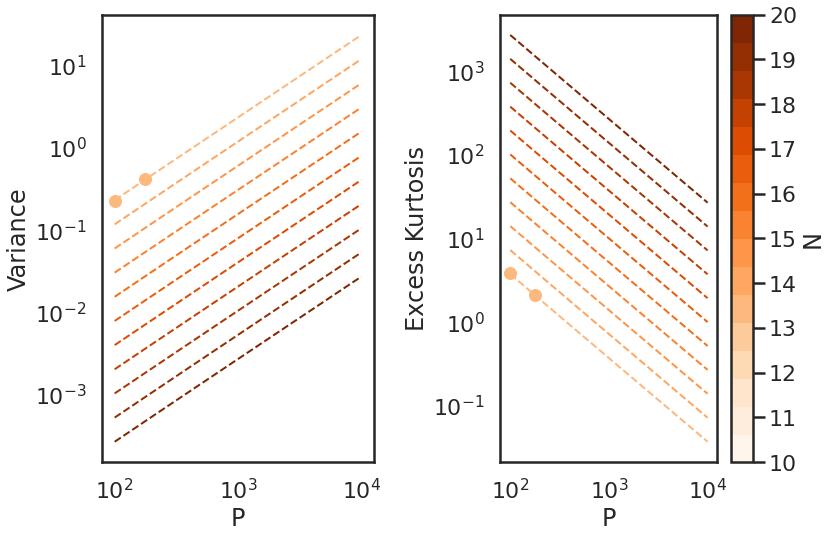

In [6]:
n_list = np.arange(10, 21)
p_list = np.floor(10 ** np.arange(2, 4.25, 0.25)).astype(int)
b = np.exp(2) / np.cosh(2)

xtalk_all = np.load('final_logs/edn_crosstalk.npy')
x_talk_var = np.var(xtalk_all, axis=2)
x_talk_kur = kurtosis(xtalk_all, axis=2)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
cmap = plt.get_cmap("Oranges", len(n_list) + 5)
colors = cmap(np.arange(len(n_list) + 5))

for ind_n in range(len(n_list)):
    ax1.plot(p_list, x_talk_var[ind_n, :], 'o', linestyle = 'None', color=colors[ind_n+5], linewidth=2)
    ax1.plot(p_list, (p_list - 1) * (b ** (1 - n_list[ind_n])), '--', color=colors[ind_n+5], linewidth=2)
    
    ax2.plot(p_list, x_talk_kur[ind_n, :], 'o', linestyle = 'None', color=colors[ind_n+5], linewidth=2)
    ax2.plot(p_list, (((np.cosh(4) / np.cosh(2) ** 2) ** (n_list[ind_n] - 1) - 3) / (p_list - 1)), '--', color=colors[ind_n+5], linewidth=2)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('P')
ax1.set_ylabel(f'Variance')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('P')
ax2.set_ylabel(f'Excess Kurtosis')

norm = plt.Normalize(n_list.min(), n_list.max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add a colorbar to the right of the plots
cbar = fig.colorbar(sm, label='N', ticks=n_list)
plt.tight_layout()
plt.savefig('plots/EDN Crosstalk.pdf', format='pdf', dpi=300)
plt.show()

# Maximal Degree of Polynomial DenseNet

In [ ]:
fig = plt.figure(figsize=(5, 7))

Ns = [10,15,20]
ds = list(range(1, 47))

max_d_trans_log = np.log10(np.load('final_logs/max_degree_capacity.npy'))
max_d_trans_log_mean, max_d_trans_log_std = np.mean(max_d_trans_log, axis=2), np.std(max_d_trans_log, axis=2)

max_d_theory_log = np.log10( np.array( [[theory_PDN_trans(N, d) for d in ds] for N in Ns] ) )

c = np.arange(1, 5)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Oranges)
cmap.set_array([])

ds = list(range(1,48))
plt.errorbar(ds[:21], max_d_trans_log_mean[0], max_d_trans_log_std[0], capsize=5, linestyle='--', color = cmap.to_rgba(2), label= 'Sim: N = 10')
plt.plot(ds[:12], max_d_theory_10_log[:12], color = cmap.to_rgba(2), label= 'Theory: N = 10')

plt.errorbar(ds[:35], max_d_trans_log_mean[1], max_d_trans_log_std[1], capsize=5, color = cmap.to_rgba(3), linestyle='--', label= 'Sim: N = 15')
plt.plot(ds[:18], max_d_theory_15_log[:18], color = cmap.to_rgba(3), label= 'Theory: N = 15')

plt.errorbar(ds[:25], max_d_trans_log_mean[2], max_d_trans_log_std[2], capsize=5, color = cmap.to_rgba(4), linestyle='--', label= 'Sim: N = 20')
plt.plot(ds[:25], max_d_theory_20_log[:25], color = cmap.to_rgba(4), label= 'Theory: N = 20')

# plt.xticks(list(range(1,48)))
plt.xlabel('d', fontsize=30)
plt.yticks(list(range(5)))
plt.ylabel('$log_{10}(P_T)$', fontsize=30)
# plt.title('Maximum Degree for Finite PDN')
plt.ylim([0,4])
plt.legend(loc = 'upper right', ncol=1, fontsize=12)
plt.tight_layout()
plt.savefig('plots/maximum_degree.pdf', format = 'pdf', dpi = 300)

# Plot Overlaps over time SeqNet, DenseNet, Temporal Association Net, and MixedNet

In [34]:
# Polynomial DenseNet
@jit
def poly_asym_update(patterns, state, dA): # Update rule for Polynomial DenseNet excluding self-coupling
    P, N = patterns.shape
    return jnp.einsum('ij,ij->j', jnp.roll(patterns,-1, axis=0), jnp.power( ((patterns@state).reshape(P,1) - (patterns*state)) / (N-1), dA))

batched_poly_asym_update = vmap((poly_asym_update), in_axes=(0, 0, None))

class PDN(object):      
    def initialize(self, patterns, tau, d_A):
        self.patterns = patterns
        self.N = patterns.shape[1]
        self.P =  patterns.shape[0]
        self.Q = self.P - 1
        self.tau = tau
        self.d_A = d_A

    def predict(self, num_timestep=1):
        self.num_timestep = num_timestep
        
        # Copy to avoid call by reference 
        self.s_history = np.vstack((np.tile(self.patterns[-1], (self.tau,1)), self.patterns[0]))
        self.alignment_history = np.zeros((self.P, self.num_timestep))
        
        # Define predict list
        for t in range(self.num_timestep - 1):            
            bitflips = self._run(t)
            # if bitflips > 0:
            #     return False, np.array(self.s_history), np.array(self.alignment_history)

        return True, np.array(self.s_history), np.array(self.alignment_history)
        
    def _run(self, timestep):
        """
        Synchronous update
        """
        # Initialize in a pattern
        t = timestep
        s = self.s_history[-1]
        
        # Update network 
        h_2 = poly_asym_update(self.patterns, s, self.d_A)
        s = jnp.sign(h_2)

        # Compute Network Alignment and add to history
        alignment = np.tensordot(self.patterns, s, 1) / self.N
        
        self.alignment_history[:,t] = alignment
        self.s_history = np.vstack((self.s_history,s))  
        
        # Compute bitflips
        bitflips = jnp.sum(jnp.absolute(s - self.patterns[timestep+1])) / 2
        return bitflips
    
N = 300
P = 100
tau = 1

# Initialize patterns
key, _ = random.split(key)
timesteps = P * tau
patterns = generate_patterns(key, N, P)

# SeqNet Simulation
model = PDN()
model.initialize(patterns, tau, 1)
success_1, system_states_1, system_alignments_1 = model.predict(timesteps)

# Polynomial DenseNet w/ d=2 Simulation
model = PDN()
model.initialize(patterns, tau, 2)
success_2, system_states_2, system_alignments_2 = model.predict(timesteps)

In [ ]:
c = np.arange(1, P+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.YlOrRd)
cmap.set_array([])

time_xticks = np.linspace(0, timesteps, 11, dtype='int')
cb_ticks = np.linspace(1, P, 11, dtype='int')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 6), constrained_layout=True)

for p in range(P):
    axes[0].plot(system_alignments_1[p], c=cmap.to_rgba(p + 1))

axes[0].plot([], [], ' ', label=f"$N = {N}$")
axes[0].plot([], [], ' ', label=f"$P = {P}$")
axes[0].set_xlabel('Time Step ($t$)', fontsize=30)
axes[0].set_xlim(0, timesteps)
axes[0].set_ylabel('Overlap ($m^{\mu})$', fontsize=30)
axes[0].set_ylim(-0.25, 1.05)
axes[0].set_xticks(time_xticks)
axes[0].set_title(f'SeqNet', size=35)

c = np.arange(1, P+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.YlOrRd)
cmap.set_array([])

for p in range(P):
    axes[1].plot(system_alignments_2[p], label = f'Pattern {p+1}', c=cmap.to_rgba(p + 1))

axes[1].set_xlabel('Time Step ($t$)', fontsize=30)
axes[1].set_xlim(0, timesteps)
axes[1].set_xticks(time_xticks)
axes[1].set_ylabel('Overlap ($m^{\mu})$', fontsize=30)
axes[1].set_ylim(-0.25, 1.05)
axes[1].set_title(f'Polynomial DenseNet', size=35)
fig.colorbar(cmap, ticks=cb_ticks, label='Pattern ($\\mathbf{\\xi}^{\\mu}$)', ax=axes.ravel().tolist())


# fig.savefig(f'plots/PDN_overlaps.pdf', dpi=300, format='pdf')
fig.savefig(f'plots/PDN_overlaps.pdf', format='pdf', dpi=300)
fig.show()

In [ ]:
# Modern Mixed Hopfield Networks
@jit
def poly_sym_update(patterns, state, N, d_S):
    P, N = patterns.shape
    return jnp.einsum('ij,ij->j', patterns, jnp.power( ((patterns@state).reshape(P,1) - (patterns*state)) / (N-1), d_S))

@jit
def poly_asym_update(patterns, state, N, d_A):
    P, N = patterns.shape
    return jnp.einsum('ij,ij->j', jnp.roll(patterns,-1, axis=0), jnp.power( ((patterns@state).reshape(P,1) - (patterns*state)) / (N-1), d_A))
    
class PMN(object):      
    def initialize(self, patterns, lambd, tau, d_S, d_A):
        self.patterns = patterns
        self.N = patterns.shape[1]
        self.P =  patterns.shape[0]
        self.Q = self.P - 1
        self.lambd = lambd
        self.tau = tau
        self.d_S = d_S
        self.d_A = d_A

    def predict(self, num_timestep):
        self.num_timestep = num_timestep
        
        # Copy to avoid call by reference 
        self.s_history = np.vstack((np.tile(self.patterns[-1], (self.tau,1)), self.patterns[0]))
        self.alignment_history = np.zeros((self.P, self.num_timestep))
        
        # Define predict list
        for t in range(self.num_timestep - 1):            
            bitflips = self._run(t)
            # if bitflips > 0:
            #     return False, np.array(self.s_history), np.array(self.alignment_history)
            # else:
            #     continue

        return True, np.array(self.s_history), np.array(self.alignment_history)
        
    def _run(self, timestep):
        """
        Synchronous update
        """
        # Initialize in a pattern
        t = timestep
        s = self.s_history[-1]
        
        # Compute s_avg
        s_avg = jnp.mean(self.s_history[-self.tau:], axis=0)
        
        # Update network 
        h_1 = poly_sym_update(self.patterns, s, self.N, self.d_S)
        h_2 = poly_asym_update(self.patterns, s_avg, self.N, self.d_A)
        s = jnp.sign(h_1 + self.lambd * h_2)

        # Compute Network Alignment and add to history
        alignment = np.tensordot(self.patterns, s, 1) / (self.N - 1)
        
        self.alignment_history[:,t] = alignment
        self.s_history = np.vstack((self.s_history,s))  

        # Compute bitflips
        bitflips = jnp.sum(jnp.absolute(s - self.patterns[t+1])) / 2
        return bitflips
    
N = 100
P = 40
lambd = 2.5
tau = 5

key, _ = random.split(key)
patterns = generate_patterns(key, N, P) 
timesteps = P * tau

# Incorrect Order / Incorrect Timing
model = PMN()
model.initialize(patterns, lambd, tau, 1, 1)
success_1, system_states_1, system_alignments_1 = model.predict(timesteps)

# Correct Order / Incorrect Timing
model = PMN()
model.initialize(patterns, lambd, tau, 2, 2)
success_2, system_states_2, system_alignments_2 = model.predict(timesteps)

# Correct Order / Correct Timing
model = PMN()
model.initialize(patterns, lambd, tau, 10, 10)
success_3, system_states_3, system_alignments_3 = model.predict(timesteps)

In [ ]:
c = np.arange(1, P+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.YlOrRd)
cmap.set_array([])

time_xticks = np.linspace(0, timesteps, 11, dtype='int')
cb_ticks = np.linspace(1, P, 11, dtype='int')

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), constrained_layout=True)

for p in range(P):
    axes[0].plot(system_alignments_1[p], c=cmap.to_rgba(p + 1))

axes[0].plot([], [], ' ', label=f"$N = {N}$")
axes[0].plot([], [], ' ', label=f"$P = {P}$")
# axes[0].legend(loc='upper right', fontsize=15)
axes[0].set_xlabel('Time Step ($t$)', fontsize=30)
axes[0].set_xlim(0, timesteps)
axes[0].set_ylabel('Overlap ($m^{\mu})$', fontsize=30)
axes[0].set_ylim(-0.25, 1.05)
axes[0].set_xticks(time_xticks)
axes[0].set_title(f'Temporal Association Network', size=35)

c = np.arange(1, P+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.YlOrRd)
cmap.set_array([])

for p in range(P):
    axes[1].plot(system_alignments_2[p], label = f'Pattern {p+1}', c=cmap.to_rgba(p + 1))

axes[1].set_xlabel('Time Step ($t$)', fontsize=30)
axes[1].set_xlim(0, timesteps)
axes[1].set_xticks(time_xticks)
axes[1].set_ylabel('Overlap ($m^{\mu})$', fontsize=30)
axes[1].set_ylim(-0.25, 1.05)
axes[1].set_title(f'Polynomial MixedNet ($d_S=2=d_A$)', size=35)

for p in range(P):
    axes[2].plot(system_alignments_3[p], label = f'Pattern {p+1}', c=cmap.to_rgba(p + 1))

axes[2].set_xlabel('Time Step ($t$)', fontsize=30)
axes[2].set_xlim(0, timesteps)
axes[2].set_xticks(time_xticks)
axes[2].set_ylabel('Overlap ($m^{\mu})$', fontsize=30)
axes[2].set_ylim(-0.25, 1.05)
axes[2].set_title(f'Polynomial MixedNet ($d_S=10=d_A$)', size=35)

fig.colorbar(cmap, ticks=cb_ticks, label='Pattern ($\\mathbf{\\xi}^{\\mu}$)', ax=axes.ravel().tolist())
fig.savefig(f'plots/PMN_overlaps.pdf', format='pdf', dpi=300)

# Polynomial MixedNet Crosstalk

In [28]:
def simulate_crosstalk(sequence, d_F, d_S, lambd, i, v):
    P, N = sequence.shape
    other_patterns = np.array([u for u in range(P) if (u != v)])

    crosstalk = - sequence[v+1,i] * jnp.sum(sequence[other_patterns+1,i]*((1/N * jnp.dot(sequence[other_patterns + 1], sequence[v]))**d_F + lambd*(1/N * jnp.dot(sequence[other_patterns], sequence[v]))**d_S))
    return crosstalk

batched_simulate_crosstalk = vmap(simulate_crosstalk, in_axes=(0, None, None, None, None, None))

def simulate_symm(sequence, d_F, d_S, lambd, i, v):
    P, N = sequence.shape
    other_patterns = np.array([u for u in range(P) if (u != v)])

    term1 = - sequence[v+1,i] * jnp.sum(sequence[other_patterns+1,i]*((1/N * jnp.dot(sequence[other_patterns + 1], sequence[v]))**d_F))
    return term1

batched_simulate_symm = vmap(simulate_symm, in_axes=(0, None, None, None, None, None))


def simulate_asym(sequence, d_F, d_S, lambd, i, v):
    P, N = sequence.shape
    other_patterns = np.array([u for u in range(P) if (u != v)])

    term2 = - sequence[v+1,i] * jnp.sum(sequence[other_patterns+1,i]*(lambd*(1/N * jnp.dot(sequence[other_patterns], sequence[v]))**d_S))
    return term2

batched_simulate_asym = vmap(simulate_asym, in_axes=(0, None, None, None, None, None))

def simulate_alpha(sequence, d_F, d_S, lambd, i, v):
    P, N = sequence.shape

    alpha = (1/N*jnp.dot(sequence[v+1], sequence[v]))**d_F + lambd    
    return alpha

batched_simulate_alpha = vmap(simulate_alpha, in_axes=(0, None, None, None, None, None))

### Compute Theoretical Calculation for X1 and leading terms to get its scaling
def compute_X1(d_F, N, P):
    ### Compute X1 for even d_F
    X1_even = 0
    for l in range(d_F+1):
        for m in range(d_F+1):
            if l+m % 2 == 0:
                X1_even += (comb(d_F,l) * comb(d_F,m) * factorial2(2*d_F-(l+m)-1)) * N**(-(l+m)/2)
    X1_even *= (P-1)/N**(d_F)

    if d_F % 2 == 0:
        return X1_even + 1
    else:
        ### Compute X1 for odd d_F
        X1_odd = 0
        for l in range(d_F+1):
            if l % 2 == 1:
                X1_odd += (comb(d_F,l) * factorial2(d_F-l-1)) * N**((-l)/2) 

        X1_odd = X1_odd**2
        X1_odd *= (P-1)*(P-2)/N**(d_F)
    
        return X1_even + X1_odd + 1

def compute_X1_leading(d_F, N, P):
    if d_F % 2 == 0:
        X1 = (factorial2(2*d_F-1)/N**d_F)*P + 1
    else:
        X1 = (factorial2(2*d_F-1)/N**d_F)*P + (factorial2(d_F)**2/N**(d_F+1))*P**2 + 1
    return X1 

### Compute Theoretical Calculation for X2 and leading terms to get its scaling
def compute_X2(d_S, N, P, lambd):
    X2 = 0
    for l in range(d_S+1):
        for m in range(d_S+1):
            if l+m % 2 == 0:
                X2 += comb(d_S, l) * comb(d_S, m) * factorial2(2*d_S-(l+m)-1) * N**(-(l+m)/2)
    X2 *= lambd**2 * (P-1) / N**(d_S)
    return X2 
    
def compute_X2_leading(d_S, N, P, lambd):
    return lambd**2*(factorial2(2*d_S - 1)/N**d_S)*P  

### Theoretical Calculation for X3 yields 0. This is corroborated by numerical simulation.

# Compute the variance and leading terms for the variance to get its scaling
def compute_variance(d_F, d_S, N, P, lambd):
    return compute_X1(d_F, N, P) + compute_X2(d_S, N, P, lambd)

def compute_variance_leading(d_F, d_S, N, P, lambd):
    return compute_X1_leading(d_F, N, P) + compute_X2_leading(d_S, N, P, lambd)

### Compute Conditional Mean and Variance
def compute_cond_mean(d_F, N, P):
    mean = 1
    if d_F % 2 == 1:
        mean_odd = 0
        for k in range(d_F+1):
            if k % 2 == 1:
                mean_odd += comb(d_F,k) * factorial2(d_F-k-1) * N**((d_F-k)/2) 
        mean_odd *= (P-2)/N**(d_F)    

        mean += mean_odd
    return mean

def compute_cond_mean_leading(d_F, N, P):
    mean = 1
    if d_F % 2 == 1:
        mean += factorial2(d_F)*(P-2)/N**((d_F+1)/2)
    return mean

def compute_cond_variance(d_F, N, P):
    var = 0
    for k in range(2*d_F+1):
        if k % 2 == 0:
            var += comb(2*d_F,k) * factorial2(2*d_F-k-1) * N**((2*d_F-k)/2) 
    var *= (P-2)/N**(2*d_F)
        
    if d_F % 2 == 1:
        var_odd = 0
        for k in range(d_F+1):
            if k % 2 == 1:
                var_odd += comb(d_F,k) * factorial2(d_F-k-1) * N**((d_F-k)/2) 
        var_odd *= (P-2)/N**(2*d_F)

        var += var_odd
    return var
        
def compute_cond_variance_leading(d_F, N, P):
    var = factorial2(2*d_F-1) * (P/N**(d_F))
    if d_F % 2 == 1:
        var += factorial2(d_F)**2 * (P/N**(d_F+1))
    return var

In [ ]:
N = 100
P = 1000
S = 1000
lambd = 2.5

fig = plt.figure(figsize=(10, 7))
d_F = 3
d_S = 3

key, _ = random.split(key)
sequences = generate_sequences(key, S, P, N)
i = np.random.choice(N) # neuron index
v = np.random.choice(range(1, P)) # pattern index
symm_sims = batched_simulate_symm(sequences, d_F, d_S, lambd, i, v)
asym_sims = batched_simulate_asym(sequences, d_F, d_S, lambd, i, v)
crosstalk_sims = batched_simulate_crosstalk(sequences, d_F, d_S, lambd, i, v)
plot = sns.histplot(symm_sims, bins=100, stat='density', color = 'red', label='Sim - Sym')
plot = sns.histplot(asym_sims, bins=100, stat='density', color = 'blue', label='Sim - Asym')
plot = sns.histplot(crosstalk_sims, bins=100, stat='density', color = 'green', label='Sim - Mixed')

# calculate the pdf
x0, x1 = plt.xlim()  # extract the endpoints for the x-axis
x_pdf = np.linspace(x0, x1, 250)
symm_var = compute_cond_variance(d_F, N, P)
symm_mean = compute_cond_mean(d_F, N, P)
symm_pdf_1 = scipy.stats.norm.pdf(x_pdf, loc = - symm_mean, scale = np.sqrt(symm_var)) / 2
symm_pdf_2 = scipy.stats.norm.pdf(x_pdf, loc =   symm_mean, scale = np.sqrt(symm_var)) / 2
plt.plot(x_pdf, symm_pdf_1 + symm_pdf_2, color = 'red', lw=3, label='Theory - Sym') 

asym_var = compute_X2(d_S, N, P, lambd)
asym_mean = 0
asym_pdf = scipy.stats.norm.pdf(x_pdf, loc = asym_mean, scale = np.sqrt(asym_var))
plt.plot(x_pdf, asym_pdf, color = 'blue', lw=3, label='Theory - Asym') 


total_var = symm_var + asym_var
total_pdf_1 = scipy.stats.norm.pdf(x_pdf, loc = - symm_mean, scale = np.sqrt(total_var)) / 2
total_pdf_2 = scipy.stats.norm.pdf(x_pdf, loc =   symm_mean, scale = np.sqrt(total_var)) / 2
plt.plot(x_pdf, total_pdf_1 + total_pdf_2, color = 'green', lw=3, label='Theory - Mixed') 

plt.legend(loc = 'upper right', prop={'size': 15}, ncol=2)
plt.title(f'MixedNet Crosstalk', fontsize = 40)
plt.xlabel('Crosstalk')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig(f"plots/MixedNet Crosstalk.pdf",  format = 'pdf', dpi=300)